[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1sNhpGxJo3ySF7tXi5JyCNT9ZRCXCfteQ?usp=sharing#scrollTo=snI5_lfiJkqW)

# Installs and Imports

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Miscellaneous/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d basilb2s/language-detection
!unzip language-detection.zip

!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
!pip install langdetect fasttext pycountry langid language_detector google-trans-new textblob polyglot gcld3

In [ ]:
import time
import pandas as pd

from pycountry import languages
from matplotlib import pyplot as plt

# Task

Comparing language identification methods (as of March 7, 2023) in terms of accuracy and speed.

## Functions

In [ ]:

class FastTextDetector:
  def __init__(self, path="/content/lid.176.bin") -> None:
    import fasttext

    self.model = fasttext.load_model(path)

  def run(self, text) -> str:
    ((lang,), [score]) = self.model.predict(text.replace('\n', ' '))
    return lang[-2:]#.strip("__label__")


class LangDetectDetector:
  def __init__(self,) -> None:
    import langdetect

    self.model = langdetect
    self.model.DetectorFactory.seed = 0


  def run(self, text) -> str:
    """
    Input: text string
    Output: language code

    Note: Only returns language code
    """
    return self.model.detect(text)


class LangIDDetector:
  def __init__(self,) -> None:
    import langid
    self.model = langid

  def run(self, text) -> str:
    """
    Input: text string
    Output: language code

    Note: Can also return confidence
    """
    return self.model.classify(text)[0]


class LanguageDetectorDetector:
  def __init__(self,) -> None:
    import language_detector
    self.model = language_detector

  def run(self, text) -> str:
    """
    Input: text string
    Output: language string

    Note: Only returns language
    """

    return self.model.detect_language(text)


class GCLD3Detector:
  def __init__(self,) -> None:
    import gcld3

    self.model = gcld3.NNetLanguageIdentifier(min_num_bytes=0, max_num_bytes=1000)

  def run(self, text) -> str:
    """
    Input: text string
    Output: language code

    Note: Can also return confidence and top n languages
    """
    return self.model.FindLanguage(text=text).language


class GoogleTranslator:
  def __init__(self,) -> None:
    from google_trans_new import google_translator

    self.model = google_translator()

  def run(self, text) -> str:
    """
    Input: text string
    Output: language code

    Note: Can also return confidence
    """
    return self.model.detect(text).language


class TextBlobDetector:
  def __init__(self,) -> None:
    from textblob import TextBlob
    self.model = TextBlob

  def run(self, text) -> str:
    """
    Input: text string
    Output: language code

    Note: Can also return confidence
    """
    return self.model(text).detect_language()


class PolyglotDetector:
  def __init__(self,) -> None:
    from polyglot.text import Text
    self.model = Text()

  def run(self, text) -> str:
    """
    Input: text string
    Output: language code

    Note: Only returns code

    """
    return self.model(text).language.code



class LangDectectionEvaluator:

  def __init__(self,) -> None:
    pass

  def run(self, df, detector_function, weights: list=None):

    start = time.time()
    predictions = []

    for text in df["Text"]:

        try:
          language = detector_function.run(text)
        except:
          #print(detector_function.__name__.strip("run_"), text)
          language = None

        predictions.append(self.__convert_predictions(language))

    duration = time.time() - start
    raw_score = self._accuracy_test(df["Language"].values.tolist(), predictions, weights)
    weighted_score = self._accuracy_test(df["Language"].values.tolist(), predictions, weights=None)

    return duration, raw_score, weighted_score


  def _accuracy_test(self, labels, preds, weights) -> float:
    """
    Weight english and spanish language heavier
    """
    from sklearn.metrics import f1_score
    from sklearn import preprocessing

    le = preprocessing.LabelEncoder()
    le.fit(list(labels)+preds)

    labels_numeric = le.transform(labels)
    preds_numeric = le.transform(preds)

    return f1_score(labels_numeric, preds_numeric, average="micro", sample_weight=weights)

  def __convert_predictions(self, prediction) -> str:
    language = None

    if prediction:
      long_name = languages.get(alpha_2=prediction)
      language = long_name.name if long_name else prediction.capitalize()

    return language


## Run

In [ ]:
# For larger scale
# https://www.kaggle.com/datasets/chazzer/big-language-detection-dataset?select=sentences.csv


df = pd.concat([
    pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/dataset.csv").rename(columns={"language": "Language"}),
    pd.read_csv("Language Detection.csv"), #"Downloads/Language Detection.csv")
]).reset_index(drop=True)
df["Language"] = df["Language"].replace("Portugeese", "Portugese").replace("Sweedish", "Swedish")


# Place 3x importance on in-use languages
weights = [3 if lang in ['English', 'Spanish',] else 1 for lang in df["Language"]]

In [ ]:
df.shape

In [ ]:
len(set(df["Language"]))

In [ ]:
detectors = {
    "FastText": FastTextDetector(),
    "LangDetect": LangDetectDetector(),
    "LangID": LangIDDetector(),
    "LanguageDetector": LanguageDetectorDetector(),
    "GCLD3": GCLD3Detector(),
    #"GoogleTranslator": GoogleTranslator(), # Broken
    #"TextBlob": TextBlobDetector(), # Broken
    #"Polygloy": PolyglotDetector(), # Broken
}

In [ ]:
le = LangDectectionEvaluator()

results = []
for detector in detectors:

  print(f"Running: {detector}")

  try:
    duration, raw_score, weighted_score = le.run(df, detector_function=detectors[detector], weights=weights)
    results.append({
        "Model": detector,
        "Runtime": duration,
        "Raw Accuracy": raw_score,
        "Weigted Accuracy": weighted_score,
    })
  except Exception as e:
    print(f"{detector} is broken: {e}")


results = pd.DataFrame(results)

In [ ]:
results = results.set_index("Model")

In [ ]:
results

,Speed,Raw Accuracy,Weigted Accuracy
Model,,,
FastText,5.420096,0.931599,0.915855
LangDetect,248.416064,0.847908,0.817083
LangID,78.369104,0.909437,0.892569
LanguageDetector,0.595114,0.416468,0.312800
GCLD3,24.871880,0.905461,0.891641


In [ ]:
def plot(df, title):

  fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(15, 15))
  fig.tight_layout(h_pad=1.5)

  SMALL_SIZE = 16
  MEDIUM_SIZE = 18
  BIGGER_SIZE = 20

  plt.rc('font', size=BIGGER_SIZE)
  plt.rc('axes', titlesize=SMALL_SIZE)
  plt.rc('axes', labelsize=MEDIUM_SIZE)
  plt.rc('xtick', labelsize=SMALL_SIZE)
  plt.rc('ytick', labelsize=SMALL_SIZE)
  plt.rc('legend', fontsize=MEDIUM_SIZE)
  plt.rc('figure', titlesize=BIGGER_SIZE)

  for i, col in enumerate(df.columns):

      df = df.sort_values(by=col, ascending=True)
      df[[col]].plot(ax=axes[i], kind="barh", xlabel='').legend(loc='lower right')

  fig.text(-0.1, 0.5, 'Model', ha='center', va='center', rotation='vertical')
  fig.suptitle(title)
  fig.subplots_adjust(top=.93)

  fig.savefig(f'{title.lower().replace(" ", "_")}.png', bbox_inches="tight")

In [ ]:
plot(results, title='Language Detection Models Comparison')

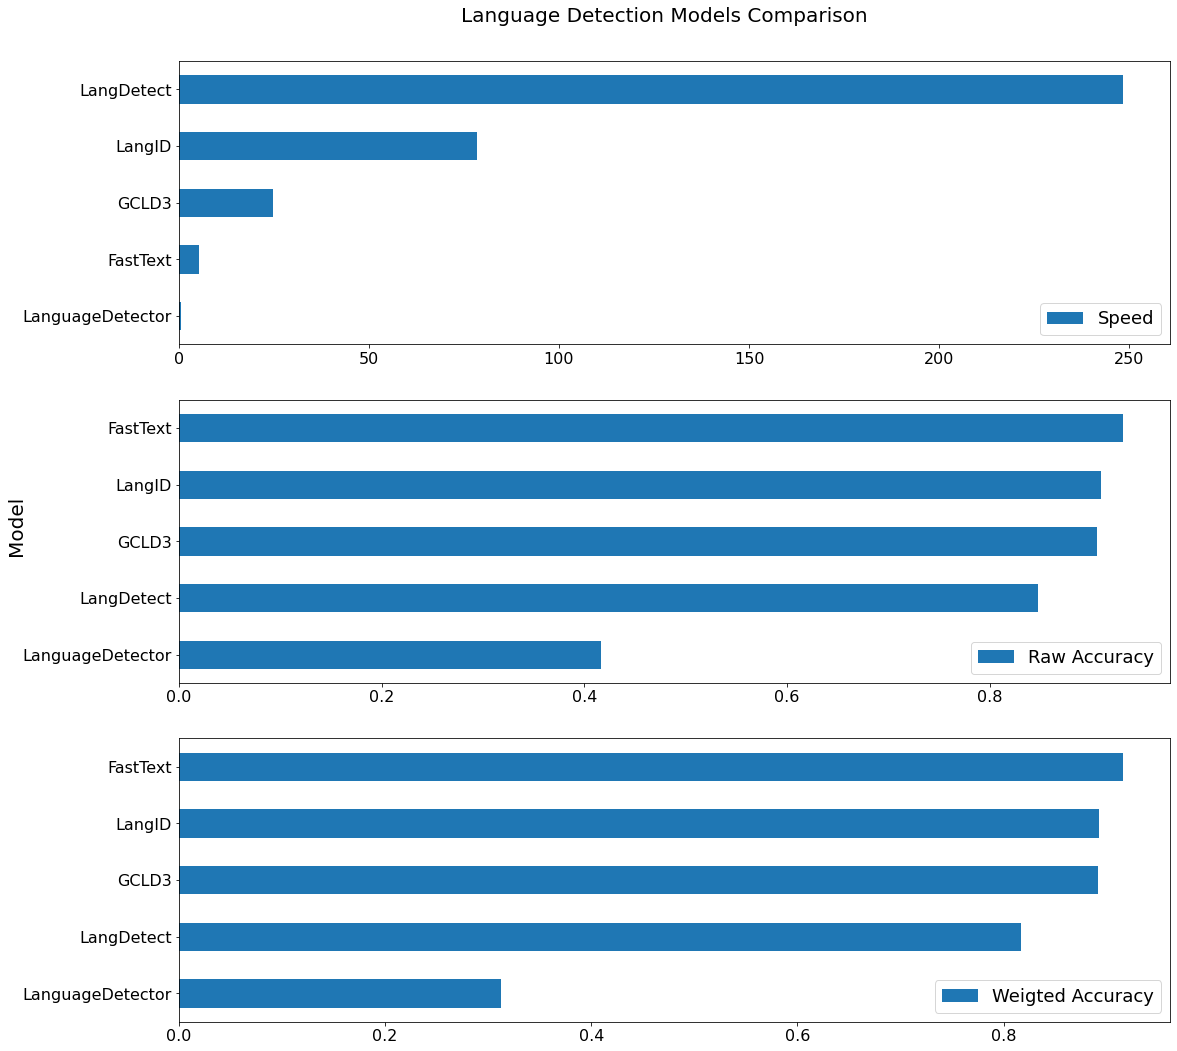

In [ ]:
plot(results, title='Language Detection Models Comparison')